# Libraries

In [8]:
# Common
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Exploratory

## Read the table

**analytic_test_booking** table contains 5 years of booking data with over 4.5 million rows. We'll need sql to perform the analysis

In [9]:
def extract_os_base(os_string):
    if not os_string or os_string.lower() in ['not found', 'unknown']:
        return 'Not found'
    if os_string.startswith("Windows NT"):
        return "Windows"

    if os_string.startswith("Chrome OS"):
        return "Chrome OS"
    if os_string in ['PlayStation','compatible','BB10','SMART-TV','SymbianOS/9.4','J2ME/MIDP','X11']:
        return 'Others'
    match = re.match(r'([a-zA-Z\s]+?)(?:\s+\d+\.?\d*\.?\d*|\s|$)', os_string)
    if match:
        base_name = match.group(1).strip()
        if base_name in ['iPhone', 'iPad', 'iPod', 'iOS']:
            return 'iOS' 
        if base_name == 'MacOS':
            return 'MacOS'
        return base_name
    return os_string.strip()

In [10]:
def clean_browser_name(browser):
    if re.match(r"^Version/.*$", browser):
        return "Safari"
    match = re.match(r"^(.+?)/.*$", browser)
    if match:
        return match.group(1)
    return browser

In [11]:
def class_type(df):
    # - avia: Business -> Class I | Economy -> Class II
# - railpass: Green Car -> Class I | Other -> Class II
# - carrent: Luxury, VIP -> CLass I | Other -> Class II 
# - daytrip: Adventure -> Class II | Sim Card -> Other
# - insurance (this one might need to be transformed in diferrent way)
# - charter: VIP, Luxury, Private,Limosine -> Class I | Others -> Class II
# - van: VIP, Luxury, Private, Limosine -> Class I | Others -> Class II
# - train: first class, 1st, VIP, deluxe -> Class I | Others -> Class II
# - ferry: VIP, premium, business -> Class I | Others -> Class II
# - bus:  VIP, Luxury, Private, Limosine -> Class I | Others -> Class II


    conditions = [
        df['vehclass_id'].str.contains('avia') & df['class_name'].str.lower().str.contains('business'),
        df['vehclass_id'].str.contains('avia') & df['class_name'].str.lower().str.contains('economy'),
        df['vehclass_id'].str.contains('railpass') & df['class_name'].str.lower().str.contains('green car'),
        df['vehclass_id'].str.contains('railpass') & (df['class_name'].str.lower().str.contains('green car') ==False),
        df['vehclass_id'].str.contains('carrent') & df['class_name'].str.lower().str.contains('luxury|vip|first'),
        df['vehclass_id'].str.contains('carrent') & (df['class_name'].str.lower().str.contains('luxury|vip|first') ==False),
        df['vehclass_id'].str.contains('daytrip') & df['class_name'].str.lower().str.contains('adventure'),
        df['vehclass_id'].str.contains('daytrip') & (df['class_name'].str.lower().str.contains('adventure') ==False),
        df['vehclass_id'].str.contains('charter') & df['class_name'].str.lower().str.contains('vip|luxury|private|limosine|premium|business|first|1st|delux|limousine'),
        df['vehclass_id'].str.contains('charter') & (df['class_name'].str.lower().str.contains('ip|luxury|private|limosine|premium|business|first|1st|delux|limousine') ==False),
        df['vehclass_id'].str.contains('van') & df['class_name'].str.lower().str.contains('vip|luxury|private|limosine|limousine|delux'),
        df['vehclass_id'].str.contains('van') & (df['class_name'].str.lower().str.contains('vip|luxury|private|limosine|limousine|delux') ==False),
        df['vehclass_id'].str.contains('train') & df['class_name'].str.lower().str.contains('first|1st|vip|deluxe|premium|business|limited|private'),
        df['vehclass_id'].str.contains('train') & (df['class_name'].str.lower().str.contains('first|1st|vip|deluxe|premium|business|limited|private') ==False),
        df['vehclass_id'].str.contains('ferry') & df['class_name'].str.lower().str.contains('vip|premium|business|platinum|private'),
        df['vehclass_id'].str.contains('ferry') & (df['class_name'].str.lower().str.contains('vip|premium|business|platinum|private') ==False),
        df['vehclass_id'].str.contains('bus') & df['class_name'].str.lower().str.contains('vip|luxury|private|limosine|first|1st|deluxe|premium|business|limited|private|super|limousine|luxurious|elite|business|platinum|gold'),
        df['vehclass_id'].str.contains('bus') & (df['class_name'].str.lower().str.contains('vip|luxury|private|limosine|first|1st|deluxe|premium|business|limited|private|super|limousine|luxurious|elite|business|platinum|gold') ==False)
    ]

    values = [
        # avia
        "Class I","Class II",
        # railpass
        "Class I","Class II",
        # carrent
        "Class I","Class II",
        # daytrip
        "Class II","Other",
        # insurance
        # "Class I","Class II",
        # charter
        "Class I","Class II",
        # van
        "Class I","Class II",
        # train
        "Class I","Class II",
        # ferry
        "Class I","Class II",
        # bus
        "Class I","Class II"
        ]

    df['class_type'] = np.select(conditions, values, default='Other')

    return df


In [12]:
def wrangle(path):
    columns=[
            #booking
            'status_id','seats',
            #seasonality, trend
            'paidon','godate','createdon',
            #financial
            'paygate_code','payment_currency','refund_date',
            'refund_usd','netprice_usd','sysfee_usd','agfee_usd',
            'total_usd','sysfee_total_usd','agfee_total_usd','netprice_total_usd',
            # route
            'from_province_id','to_province_id',
            'from_country_id','to_country_id','from_station_name','to_station_name','vehclass_id','trip_duration_minutes','class_name',
            # operator_id,
            'createdby_role_id',
            # customer
            'cust_id','channel','useragent','user_agent','referer','landing','user_origin_country_id'
             ]
    df = pd.read_parquet(path,columns=columns)

    df['cal_total_usd'] = (df['netprice_usd'] + df['sysfee_usd'] + df['agfee_usd'])*df['seats']
    df['cal_sysfee_total_usd'] = df['sysfee_usd']*df['seats']
    df['cal_agfee_total_usd'] = df['agfee_usd']*df['seats']
    df['cal_netprice_total_usd'] = df['netprice_usd']*df['seats']
    df['sysfee_pct'] = df['sysfee_total_usd'] / df['total_usd']
    df['agfee_pct'] = df['agfee_total_usd'] / df['total_usd']
    df['cal_sysfee_pct'] = df['sysfee_total_usd'] / df['total_usd']
    df['cal_agfee_pct'] = df['agfee_total_usd'] / df['total_usd']

    df['travel_type'] = np.where(df['from_country_id'] == df['to_country_id'], 'Domestic', 'International')
    df['from_location'] = df['from_province_id'].astype(str) + '-' + df['from_country_id'].astype(str)
    df['to_location'] = df['to_province_id'].astype(str) + '-' + df['to_country_id'].astype(str)
    df['route_id'] = df.apply(lambda x: " | ".join(sorted([x['from_location'], x['to_location']])) , axis=1)

    df['referer_domain'] = df['referer'].str.extract(r'http(?:s?):\/\/.*?([^\.\/]+?\.[^\.]+?)(?:\/|$)')[0]
    df['referer_domain'] = df['referer_domain'].str.extract(r'(\w+)\.\w+')[0]
    df["device_type"] = df["useragent"].str.split(",").str[0]

    os_pattern = r"\(([^;)]+)(?:;[^)]+)?\)"
    browser_pattern = r"(?:Chrome|Firefox|Safari|Edge|Opera|Version)\/([\d.]+)"
    device_pattern = r"\(([^;\s]+)"
    df["os"] = df['user_agent'].apply(lambda x: re.search(os_pattern, str(x)).group(1) if re.search(os_pattern, str(x)) else "Not found")
    df['os'] = df['os'].apply(extract_os_base)
    df["browser"] = df['user_agent'].apply(lambda x: re.search(browser_pattern, str(x)).group(0) if re.search(browser_pattern, str(x)) else "Not found")
    df['browser'] = df['browser'].apply(clean_browser_name)
    df["device"] = df['user_agent'].apply(lambda x: re.search(device_pattern, str(x)).group(1) if re.search(device_pattern, str(x)) else "Not found")
    df['device'] = np.where(df['device'].str.contains('iPhone|Linux|Macintosh|Not found|iPad|Windows'), df['device'],'Others' )
    df["channel"] = df["channel"].apply(lambda x: "unknown" if x=="" else x)

    df['booked_n_days_before']= (df['godate'].dt.date - df['createdon'].dt.date).map(lambda x: x.days)

    first_purchase = df.groupby(['cust_id'])['createdon'].agg(['min']).reset_index()
    first_purchase.rename(columns={'min':'first_purchase_date'}, inplace=True)
    df = df.merge(first_purchase, on='cust_id', how='left')
    df['purchase_type'] = df.apply(lambda x: 'First purchase' if x['createdon'] == x['first_purchase_date'] else 'Repeat purchase', axis=1)

    df= class_type(df)

    drop_columns=['referer','from_location','to_location','useragent','user_agent','landing',"from_province_id","to_province_id","to_country_id","class_name"]


    df.drop(columns=drop_columns, inplace=True, axis=1)

    return df

In [13]:
df = wrangle(path=os.path.join(os.getcwd(),'output.parquet'))
# df.head()

In [14]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4505674 entries, 0 to 4505673
Data columns (total 44 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   status_id               object        
 1   seats                   uint8         
 2   paidon                  datetime64[us]
 3   godate                  datetime64[us]
 4   createdon               datetime64[us]
 5   paygate_code            object        
 6   payment_currency        object        
 7   refund_date             datetime64[us]
 8   refund_usd              float32       
 9   netprice_usd            float32       
 10  sysfee_usd              float32       
 11  agfee_usd               float32       
 12  total_usd               float32       
 13  sysfee_total_usd        float32       
 14  agfee_total_usd         float32       
 15  netprice_total_usd      float32       
 16  from_country_id         object        
 17  from_station_name       object        
 18  to

## Reviewing data

### String fields

In [15]:
df.groupby(['paygate_code'])['status_id'].agg(['count']).sort_values(by='count',ascending=False).head(20)

,count
paygate_code,
ecommpay,1741214
omise3ds,579811
ecommpay_applepay,559685
scb_qr_th,260755
omisesgd,227713
paypalrest-sg,211277
ecommpay_googlepay,155615
paypalrest,154025
direct,148894


status_id:  ['CONFIRMED' 'REFUNDED' 'FAILED' 'CANCELED' 'PAID']


<Figure size 1000x600 with 0 Axes>

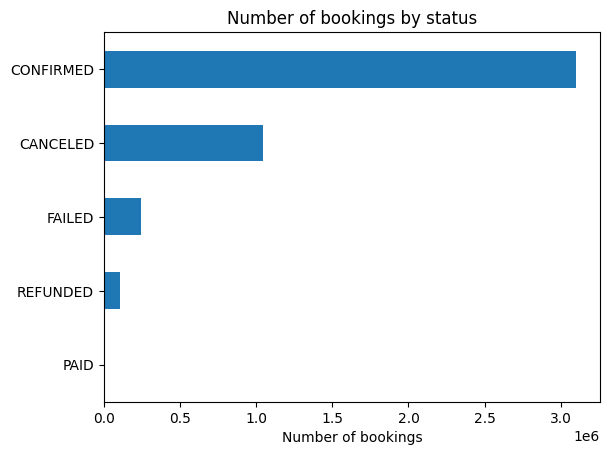

In [16]:
print("status_id: ",df["status_id"].unique())

plt.figure(figsize=(10, 6))
df.groupby(['status_id'])['status_id'].agg(['count']).sort_values(by='count').plot(kind='barh',legend=False)
plt.ylabel('')
plt.xlabel('Number of bookings')
plt.title('Number of bookings by status')
plt.show()


Why the number of paid bookings is nearly 0, what does "PAID" mean?

paygate_code:  ['omise3ds' 'paypal' 'direct' 'dragonpay' 'tmp' 'paypalrest' 'omise'
 'omisesgd' 'alipay' 'truemoney' 'gcash' 'stripe-cards' 'ecommpay'
 'wechat' 'internet_banking_bbl' 'internet_banking_ktb'
 'internet_banking_scb' 'paypalrest-sg' 'ap-direct-pay-eu'
 'ap-astro-pay-direct' 'internet_banking_bay' 'ecommpay_applepay'
 'razer_online_bank' 'ecommpay_googlepay' 'scb_qr_th' 'ecommpay_alipay'
 'omise_truemoney' 'dp_seven_eleven' 'scb_easy_th'
 'ecommpay_ind_virt_accounts' 'ecommpay_brazil_online_banking'
 'midtrans_go_pay' 'linepay_th' 'bill_payment_tesco_lotus'
 'midtrans_bni_va' 'razer_seven_eleven' 'ecommpay_sofort' 'midtrans_va'
 'midtrans_permata_va' 'ecommpay_multibanco' 'ecommpay_mexico_cash_bank'
 'ecommpay_blik' 'omisesgd_paynow' 'ecommpay_cup_quickpay' 'card_proxy'
 'ecommpay_cup_union']


<Figure size 1000x600 with 0 Axes>

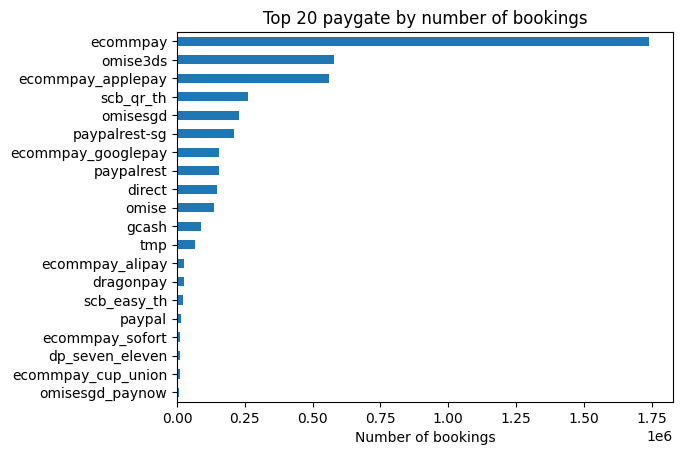

In [17]:
print("paygate_code: ",df["paygate_code"].unique())

plt.figure(figsize=(10, 6))
df.groupby(['paygate_code'])['status_id'].agg(['count']).sort_values(by='count').tail(20).plot(kind='barh',legend=False)
plt.ylabel('')
plt.xlabel('Number of bookings')
plt.title('Top 20 paygate by number of bookings')
plt.show()


Payment was made dominantly through **ecommpay, omise, paypal**. Some payment gate may appear multiple times due to multiple provider (assumed) should be grouped to simplify analysis. (46 different values in paygate_code field)

payment_currency:  ['THB' 'PHP' 'USD' 'EUR' 'INR' 'VND' 'MYR' 'SGD' 'HKD' 'IDR' 'NZD' 'LKR'
 'JPY' 'TWD' 'BRL' 'RUB' 'AUD' 'MXN' 'CAD' 'NPR' 'ZAR' 'BYN' 'TRY' 'ARS'
 'GEL' 'MAD' 'KRW' 'SEK' 'RON' 'LAK' 'PLN' 'UAH' 'GBP' 'MMK' 'UZS' 'CLP'
 'KZT' 'CHF' 'AED' 'ISK' 'BAM' 'COP' 'PEN' 'HUF' 'PYG' 'MKD' 'NOK' 'CNY'
 'AZN']


<Figure size 1000x600 with 0 Axes>

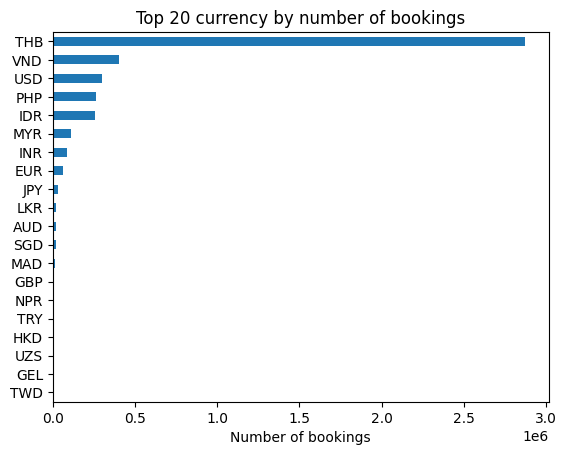

In [18]:
print("payment_currency: ",df["payment_currency"].unique())
plt.figure(figsize=(10, 6))
df.groupby(['payment_currency'])['status_id'].agg(['count']).sort_values(by='count').tail(20).plot(kind='barh',legend=False)
plt.ylabel('')
plt.xlabel('Number of bookings')
plt.title('Top 20 currency by number of bookings')
plt.show()


Payment mostly made by APAC region currency, especially in THB. Roughtly 8% of the booking was made by western currency.

<Figure size 1000x600 with 0 Axes>

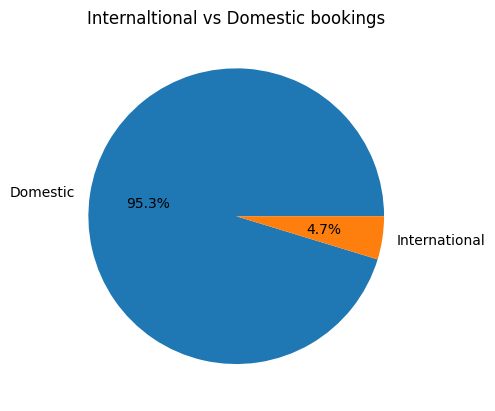

In [19]:

plt.figure(figsize=(10, 6))
df.groupby(['travel_type'])['status_id'].agg(['count']).plot(kind='pie',legend=False,y='count',autopct='%1.1f%%')
plt.ylabel('')
plt.title('Internaltional vs Domestic bookings')
plt.show()

<!-- ![International vs Domestic bookings](./images/international_domestic_bookings.jpeg) -->
95% of the bookings are domestic travel, in details, it was within APAC region, dominantly in Thailand. Should drop from/to country and use from/to province to capture booking behavior.

<Figure size 1000x600 with 0 Axes>

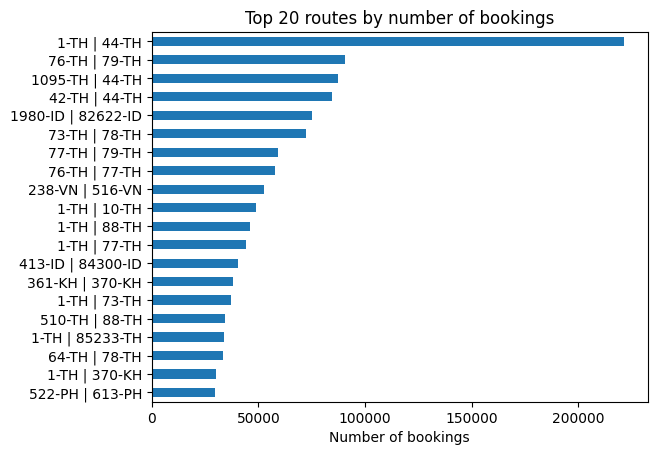

In [20]:
plt.figure(figsize=(10, 6))
df[df['vehclass_id']!='insurance'].groupby(['route_id'])['status_id'].agg(['count']).sort_values(by='count').tail(20).plot(kind='barh',legend=False)
plt.ylabel('')
plt.xlabel('Number of bookings')
plt.title('Top 20 routes by number of bookings')
plt.show()


<!-- ![popular travel routes by bookings](./images/popular_travel_routes_by_bookings.jpeg) -->
Top 20 popular travel routes (regardless of direction) by bookings. These routes accumulate for 50% of all bookings (removed DUMMY station). For more detail, Top 60 routes out of 117 routes accumulate for 80% of all bookings. Also, 99.66% of bookings were sold via agent and partner.

<Figure size 1000x600 with 0 Axes>

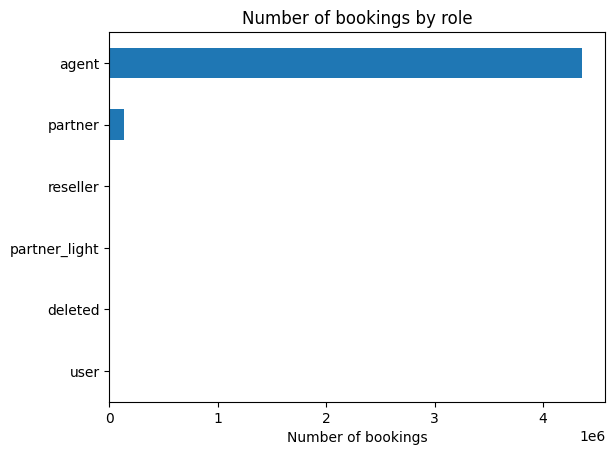

In [21]:
plt.figure(figsize=(10, 6))
df.groupby(['createdby_role_id'])['status_id'].agg(['count']).sort_values(by='count').plot(kind='barh',legend=False)
plt.ylabel('')
plt.xlabel('Number of bookings')
plt.title('Number of bookings by role')
plt.show()

In [ ]:
data = df.groupby(["vehclass_id","class_name"])["statu"].agg("count").reset_index().sort_values(by='bid',ascending=False)
print(data.shape)
data.head(20)

In [ ]:
print(
    data.groupby(["vehclass_id"])["class_name"].agg("count").reset_index().sort_values(by='class_name',ascending=False)
)

There are 1053 unique pair of vehclass_id and class_name. Some vehicles offer multiple and might be un-standardize convention. **class_name** must be grouped and standardize to simplify analysis.
Classification options with Class I for premium option, Class II for standard or below option, meaning saving:
- avia: Business & Economy -> Class I & Class II
- railpass: Green Car -> Class I | Other -> Class II
- carrent: Luxury, VIP -> CLass I | Other -> Class II 
- daytrip: Adventure -> Class II | Sim Card -> Other
- insurance (this one might need to be transformed in diferrent way)
- charter: VIP, Luxury, Private,Limosine -> Class I | Others -> Class II
- van: VIP, Luxury, Private, Limosine -> Class I | Others -> Class II
- train: first class, 1st, VIP, deluxe -> Class I | Others -> Class II
- ferry: VIP, premium, business -> Class I | Others -> Class II
- bus:  VIP, Luxury, Private, Limosine -> Class I | Others -> Class II

<Figure size 1000x600 with 0 Axes>

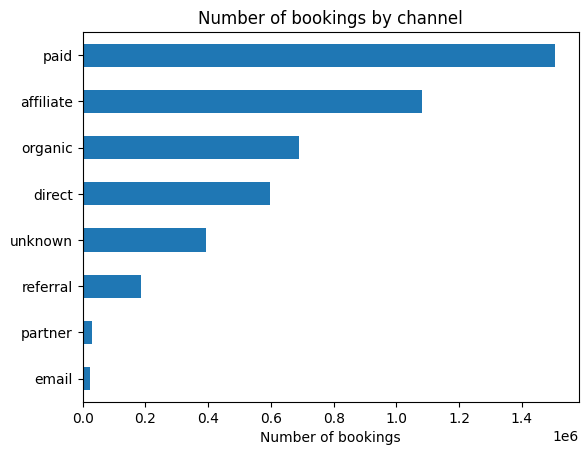

In [24]:
plt.figure(figsize=(10, 6))
df.groupby(['channel'])['status_id'].agg(['count']).sort_values(by='count').plot(kind='barh',legend=False)
plt.ylabel('')
plt.xlabel('Number of bookings')
plt.title('Number of bookings by channel')
plt.show()

Channel have some un-desired values (empty space, unknow). 80-85% of bookings were made via top 4 channel.

Booking dominantly refered from search engine, especially goole. The values need to be grouped into domain to simplify analysis.

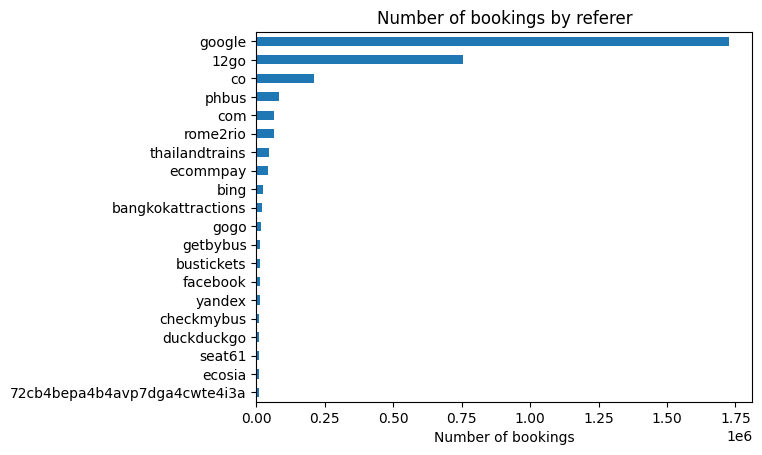

In [25]:
df.groupby(['referer_domain'])['status_id'].agg(['count']).sort_values(by='count').tail(20).plot(kind='barh',legend=False)
plt.ylabel('')
plt.xlabel('Number of bookings')
plt.title('Number of bookings by referer')
plt.show()

In [ ]:
df.groupby(['landing'])['status_id'].agg(['count']).sort_values(by='count').tail(20).plot(kind='barh',legend=False)
plt.ylabel('')
plt.xlabel('Number of bookings')
plt.title('Number of bookings by landing page')
plt.show()

Lots of bookings are landing on manifest file, this is strange. Booking was dominantly landing on home page for each region, this column might not have hidden insights. 

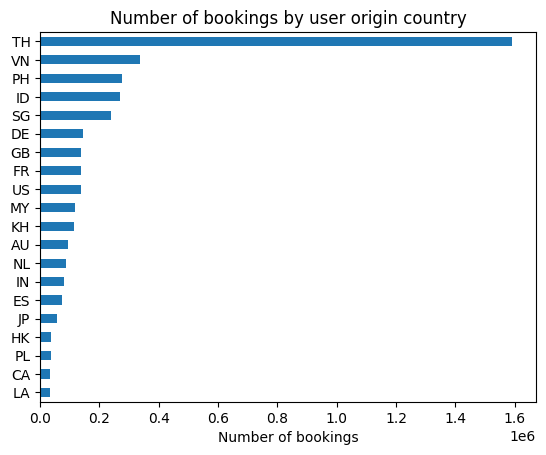

In [27]:
df.groupby(['user_origin_country_id'])['status_id'].agg(['count']).sort_values(by='count').tail(20).plot(kind='barh',legend=False)
plt.ylabel('')
plt.xlabel('Number of bookings')
plt.title('Number of bookings by user origin country')
plt.show()

Adding with above information, we can confirm that this app is primarily operating within APAC region, especially in Thailand. International market play lesser role here. But while the number of bookings from westerner are higher than number of internaltional travel, with most of bookings were made by agent and partner, suggesting that westerner come to the region then using 12go, or in short, self traveling.

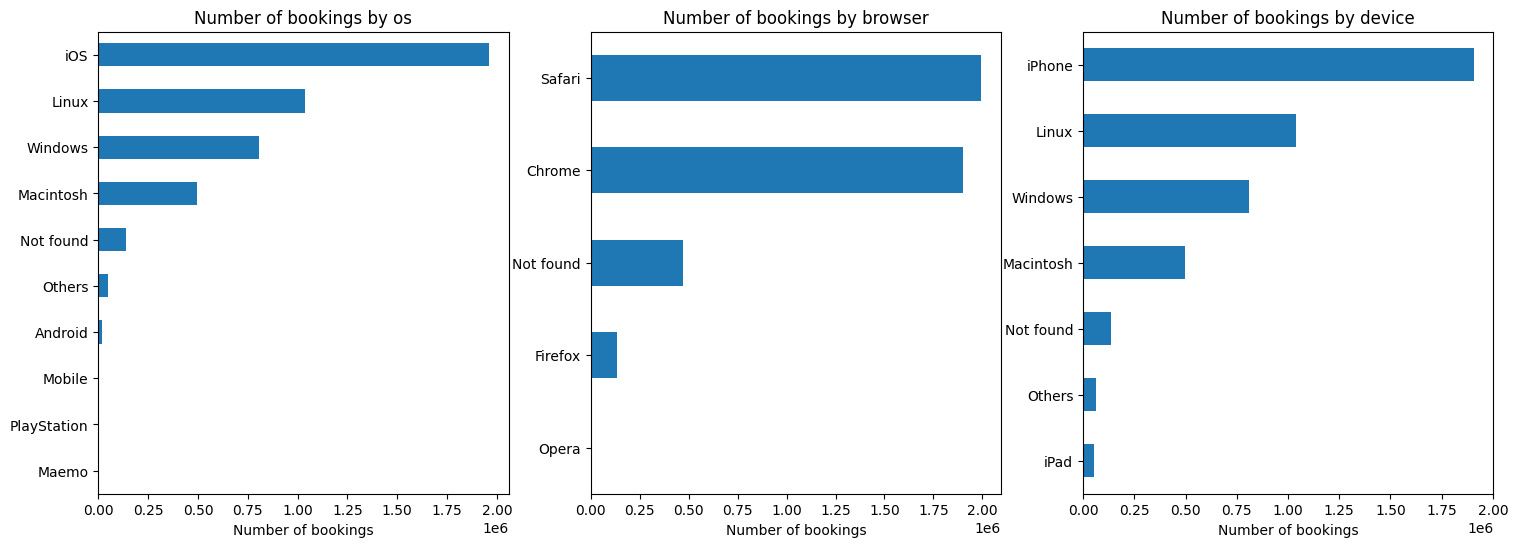

In [28]:
fig,ax = plt.subplots(figsize=(18, 6),ncols=3)
cols = ['os','browser','device']

for i,col in enumerate(cols):
    df.groupby([col])['status_id'].agg(['count']).sort_values(by='count').tail(20).plot(kind='barh',legend=False,ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('Number of bookings')
    ax[i].set_title(f'Number of bookings by {col}')
plt.show()

Above chart showing that the booking was made in popular os/device and browser. However, the browser can be better grouped into some famous name only.

### Numeric fields

In [29]:
df.describe().transpose()

/Users/chienle/.pyenv/versions/3.9.10/lib/python3.9/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/chienle/.pyenv/versions/3.9.10/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/chienle/.pyenv/versions/3.9.10/lib/python3.9/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/chienle/.pyenv/versions/3.9.10/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,min,25%,50%,75%,max,std
seats,4505674.0,1.861533,1.0,1.0,2.0,2.0,140.0,1.067545
paidon,3217702,2022-08-17 10:04:05.458576,2019-01-01 00:03:13,2023-01-13 03:18:55.250000,2023-05-13 15:47:35.500000,2023-10-01 22:39:47.250000,2024-03-06 08:19:43,NaN
godate,4505674,2022-10-16 03:08:50.645249,2019-01-01 08:00:00,2023-02-05 12:30:00,2023-06-21 22:00:00,2023-11-02 09:30:00,2029-01-18 07:00:00,NaN
createdon,4505674,2022-10-01 22:18:01.783619,2019-01-01 00:01:56,2023-01-27 22:17:20.750000,2023-06-08 13:43:46.500000,2023-10-21 19:17:34,2023-12-31 23:59:49,NaN
refund_date,194453,2022-02-18 22:10:54.386557,2019-01-01 07:57:13,2019-10-30 14:57:03,2023-04-12 15:42:15,2023-10-15 10:21:41,2024-08-13 19:40:27,NaN
refund_usd,448666.0,14.051356,-523.130005,0.0,0.0,8.827499,2388.040039,40.979977
netprice_usd,4505674.0,20.956146,-126.330002,5.23,12.72,24.01,571500.0,734.055054
sysfee_usd,4505674.0,3.294009,-904.530029,1.59,2.19,3.75,57150.0,29.71014
agfee_usd,4505674.0,0.613412,-1.25,0.0,0.0,0.86,138.979996,1.323501
total_usd,4505674.0,44.591702,-236.399994,10.83,25.639999,50.82,628650.0,749.048706


We can notice there are outliers within the data. Assuming this is production data, the system might incorrectly capture some data
- Negative net price, system fee, agent fee, refund, trip duration
- The seats booked is maxed at 140, is this a typo, wrong order or anything? It should align with financial data
- Longest trip duration was 44940 mins, equal to 31 days -> something not right here, especially when 95% of the trips are domestic

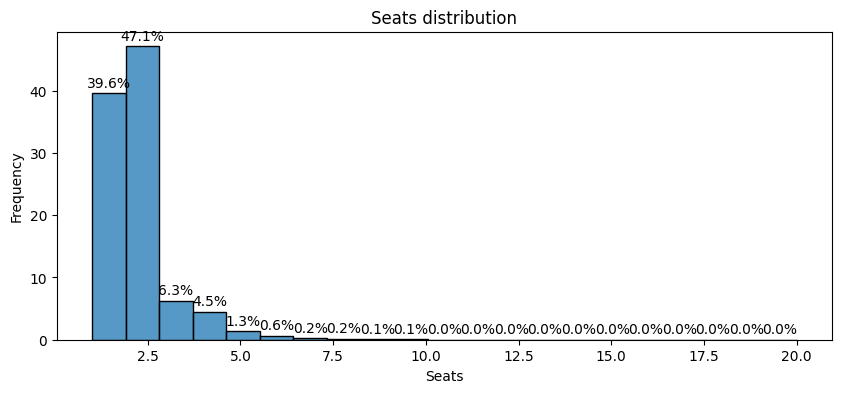

In [ ]:
plt.figure(figsize=(10, 4))
sns.histplot(data=df[df['seats'] <= 20], x='seats', bins=21, stat='percent')
counts, bins = np.histogram(df[df['seats'] <= 20]['seats'], bins=21, weights=[1/len(df[df['seats'] <= 20]['seats'])*100]*len(df[df['seats'] <= 20]['seats']))
for i in range(len(counts)):
    plt.text(bins[i] + (bins[i+1] - bins[i])/2, counts[i] + 1, f'{counts[i]:.1f}%', ha='center')
plt.ylabel('Frequency')
plt.xlabel('Seats')
plt.title('Seats distribution')
plt.show()

With bookings below 10 seats already cover nearly 99.9% of the dataset, suggesting booking with above seats are abnormal or edge cases. Further examine showing that the booking is valid, slightly different in the total and per seat due to rounding in the calculation. However, for more generic analysis purpose, this booking should be eliminated from the dataset.

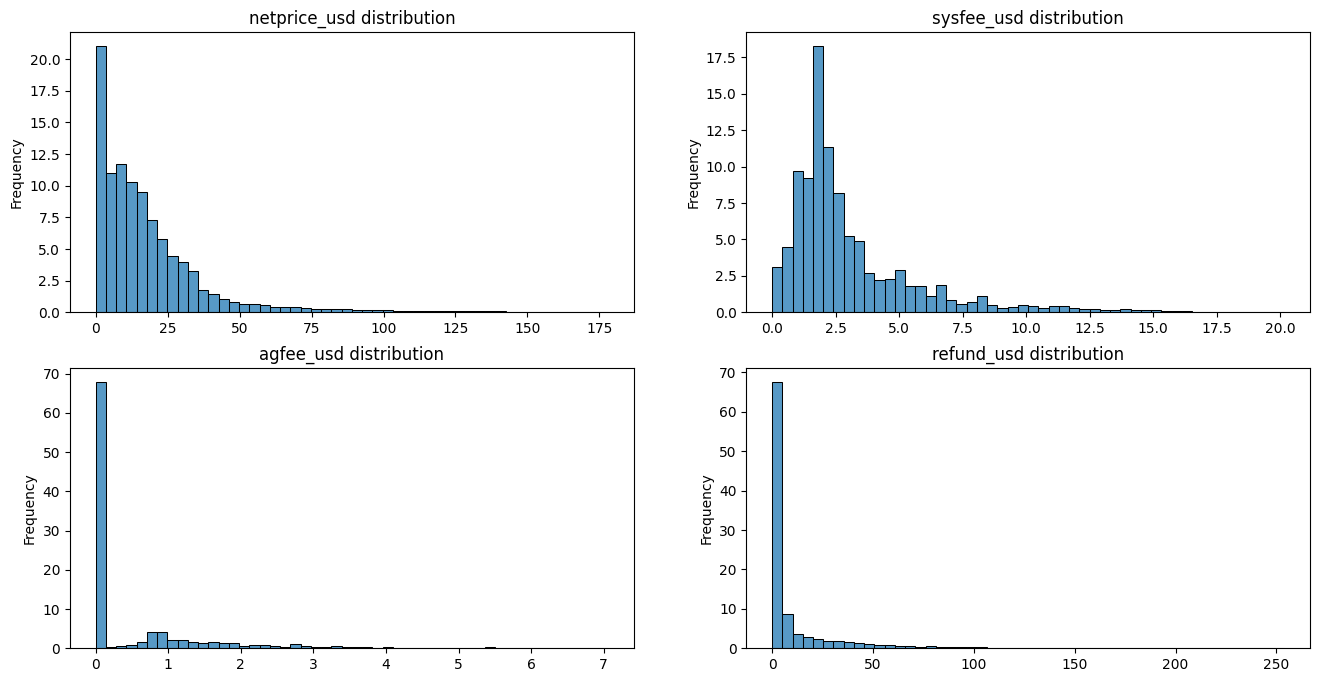

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8), ncols=2,nrows=2)
columns = ['netprice_usd','sysfee_usd','agfee_usd','refund_usd']

for i, col in enumerate(columns):
    sns.histplot(data=df[(df[col].isna()==False) & (df[col] <= df[col].quantile(0.995)) & (df[col] >= df[col].quantile(0.005))], x=col, bins=50, stat='percent',ax=ax[i//2,i%2])
    ax[i//2,i%2].set_ylabel('Frequency')
    ax[i//2,i%2].set_xlabel('')
    ax[i//2,i%2].set_title(f'{col} distribution')
plt.show()

The above chart was filtering 99% of the data for each field.
- net_price mostly ranged between 0 to $25 per seat
- system fee ranged betwwen 0 to $5 per seat
- agent fee ranged between 0 to $2 per seat
- refund often ranged between 0 to $50 per seat

The next step should be verify if the fee was normal/reasonable. Let's calculate the fee percentage over total value

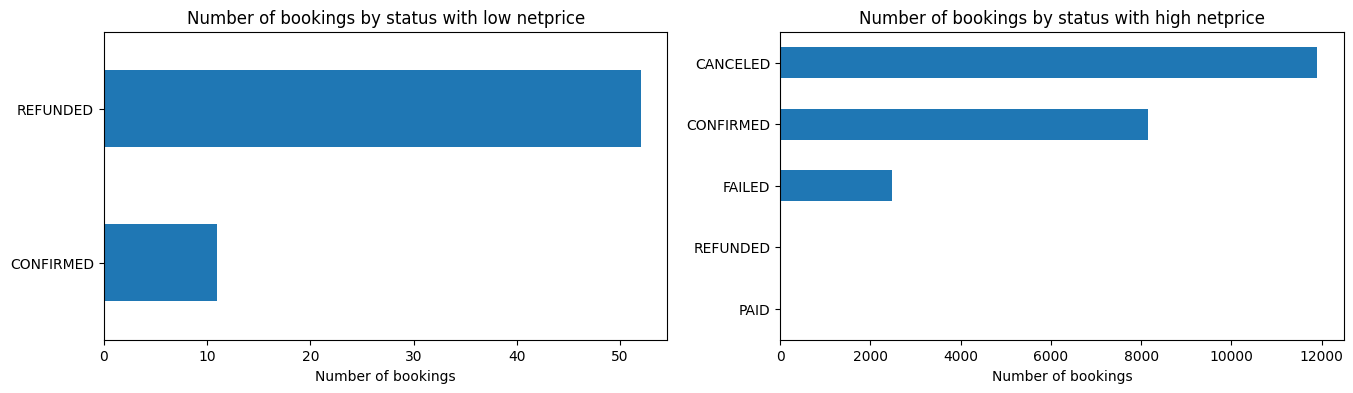

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4),ncols=2)

df[df['netprice_usd'] < df['netprice_usd'].quantile(0.005)].groupby(['status_id'])['status_id'].agg(['count']).sort_values(by='count').plot(kind='barh',legend=False,ax=ax[0])
ax[0].set_ylabel('')
ax[0].set_xlabel('Number of bookings')
ax[0].set_title('Number of bookings by status with low netprice')
df[ (df['netprice_usd'] > df['netprice_usd'].quantile(0.995))].groupby(['status_id'])['status_id'].agg(['count']).sort_values(by='count').plot(kind='barh',legend=False,ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_xlabel('Number of bookings')
ax[1].set_title('Number of bookings by status with high netprice')
plt.show()


In [ ]:
print("Total USD diff: ", (df["total_usd"] - df["cal_total_usd"]).sum())
print("Total System fee diff: ", (df["sysfee_total_usd"] - df["cal_sysfee_total_usd"]).sum())
print("Total Agent fee diff: ",(df["agfee_total_usd"] - df["cal_agfee_total_usd"]).sum())

Total USD diff:  35538.008
Total System fee diff:  2012733.0
Total Agent fee diff:  -2095009.5


In [ ]:
(df["agfee_total_usd"] - df["cal_agfee_total_usd"]).describe()

count    4.505674e+06
mean    -4.649714e-01
std      1.859303e+00
min     -1.419600e+02
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.900000e+00
dtype: float64

In [ ]:
df[['agfee_total_usd','total_usd','agfee_pct','agfee_usd','seats']]

,agfee_total_usd,total_usd,agfee_pct,agfee_usd,seats
0,0.00,77.750000,0.000000,5.30,2
1,0.00,77.750000,0.000000,5.30,2
2,6.40,76.739998,0.083398,3.22,2
3,5.30,118.919998,0.044568,2.65,2
4,0.00,24.740000,0.000000,2.65,1
...,...,...,...,...,...
4505669,0.00,10.300000,0.000000,0.00,4
4505670,0.00,32.750000,0.000000,0.00,2
4505671,0.00,74.540001,0.000000,0.00,2
4505672,3.27,60.709999,0.053863,1.64,2


Above charts showing that low value net_price are mostly refunded bookings, it's still unclear to understand the negative value. However, the count was low (just above 60), maybe the bookings was made by agent/operator to adjust the balance?

With high netprice bookings, most of them get canceled but around 1/3 still confirmed, maybe these are urgent bookings, can check with createdon and godate.

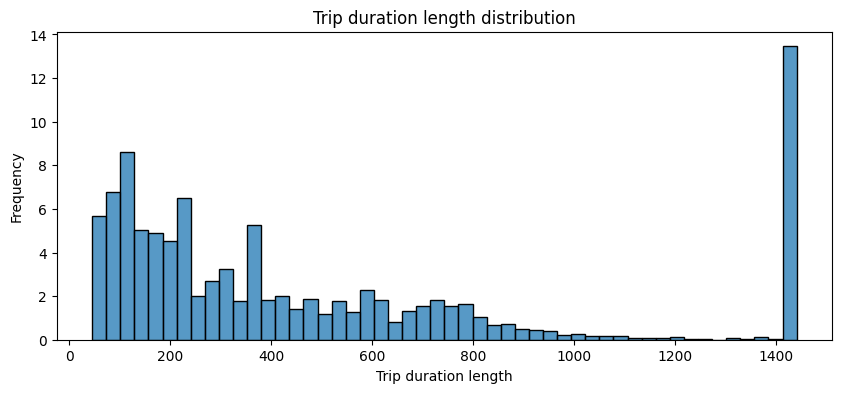

In [ ]:
plt.figure(figsize=(10, 4))
sns.histplot(
    data=df[
        (df['trip_duration_minutes'].isna()==False) 
        & (df['trip_duration_minutes'] <= df['trip_duration_minutes'].quantile(0.95)) 
        & (df['trip_duration_minutes'] >= df['trip_duration_minutes'].quantile(0.05))
        ], 
    x='trip_duration_minutes', bins=50, stat='percent')
plt.ylabel('Frequency')
plt.xlabel('Trip duration length')
plt.title('Trip duration length distribution')
plt.show()

90% of the trips are from 0 to 1400 mins (1day). Further examination shows that:
- Negative duration trip are mostly confirmed and travelled by ferry. Might due to misconfigurations from the seller?
- Suspiciously high trip duration are mainly from insurance bookings. The values trip duration might be 6hrs, 1 day and 15 days. However, the highest duration are train and ferry trips, maybe these are high luxury trips?

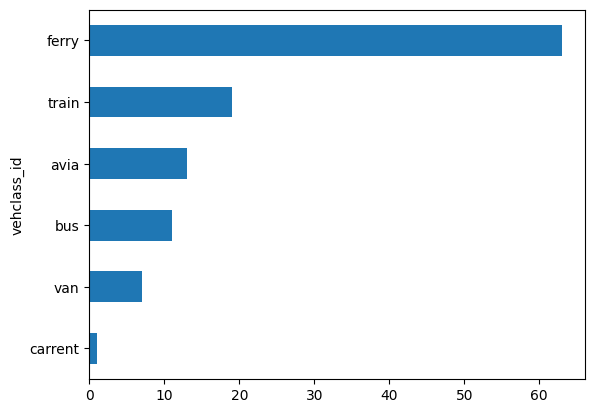

In [ ]:
df[df['trip_duration_minutes'] < 0].groupby(['vehclass_id'])['status_id'].agg(['count']).sort_values(by='count').plot(kind='barh',legend=False)
plt.show()

<Axes: ylabel='vehclass_id'>

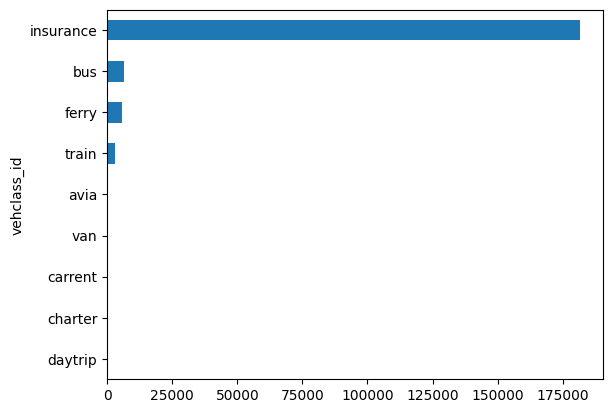

In [ ]:
df[(df['trip_duration_minutes'] > df['trip_duration_minutes'].quantile(0.95))].groupby(['vehclass_id'])['status_id'].agg(['count']).sort_values(by='count').plot(kind='barh',legend=False)

### Datetime fields

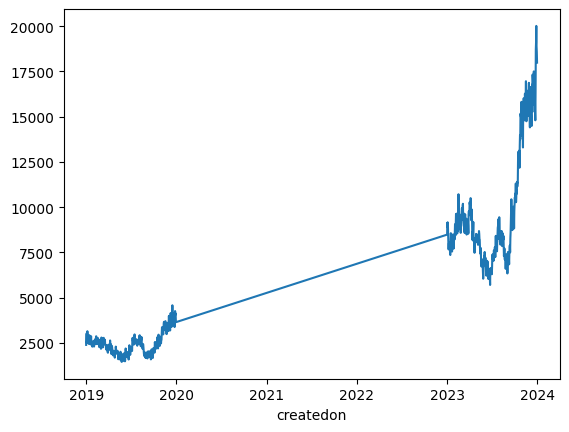

In [ ]:
df["createdon"].dt.date.value_counts().sort_index().plot(legend=False)
plt.show()

In [ ]:
df['booked_n_days_before'].describe()

count    4.505674e+06
mean     1.424742e+01
std      2.988170e+01
min     -3.610000e+02
25%      1.000000e+00
50%      3.000000e+00
75%      1.300000e+01
max      2.194000e+03
Name: booked_n_days_before, dtype: float64

The mean of dates between booked date and go date are 13days. However, there are some bookings was way after the go date. Needs more examination

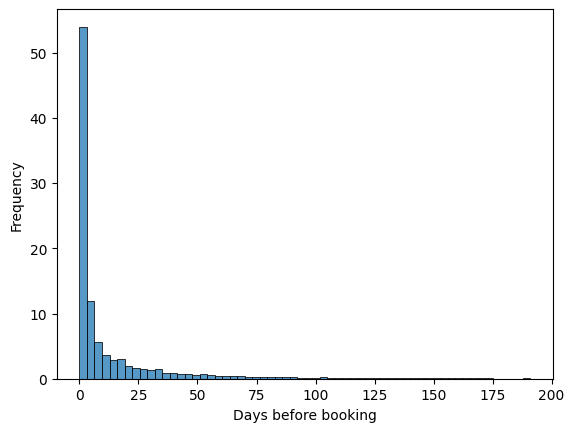

In [ ]:
sns.histplot(
    data = df[
        (df['booked_n_days_before'] >= df['booked_n_days_before'].quantile(0.005)) 
        & (df['booked_n_days_before'] <= df['booked_n_days_before'].quantile(0.995))
        ],
    x='booked_n_days_before', bins=60, stat='percent')
plt.ylabel('Frequency')
plt.xlabel('Days before booking')
plt.show()

99% of trips were booked before go date ~30 days (1 months) and maxed around 6 months. Further examination didn't find any suspicious data for trip booked after godate.

In [ ]:
df[(df['booked_n_days_before'] < 0) ].head().transpose()

,286048,329295,331797,349714,387891
status_id,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED,CONFIRMED
seats,1,2,2,3,2
paidon,2019-04-27 10:18:06,2019-05-20 00:51:14,2019-05-21 10:39:20,2019-06-01 10:36:03,2019-06-22 10:58:55
godate,2019-04-26 13:30:00,2019-05-19 09:00:00,2019-05-20 13:30:00,2019-05-31 18:00:00,2019-06-21 13:30:00
createdon,2019-04-27 10:18:06,2019-05-20 00:51:13,2019-05-21 10:39:20,2019-06-01 10:36:02,2019-06-22 10:58:55
paygate_code,direct,direct,direct,direct,direct
payment_currency,THB,THB,THB,THB,THB
refund_date,NaT,NaT,NaT,NaT,NaT
refund_usd,NaN,NaN,NaN,NaN,NaN
netprice_usd,11.09,12.21,11.11,7.26,11.52


<Axes: ylabel='status_id'>

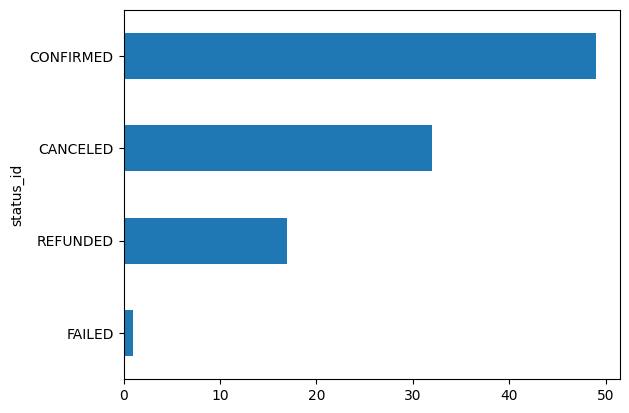

In [ ]:
df[(df['booked_n_days_before'] <0) & (df['vehclass_id'] != 'insurance')].groupby(['status_id'])['status_id'].agg(['count']).sort_values(by='count').plot(kind='barh',legend=False)

<Axes: ylabel='createdby_role_id'>

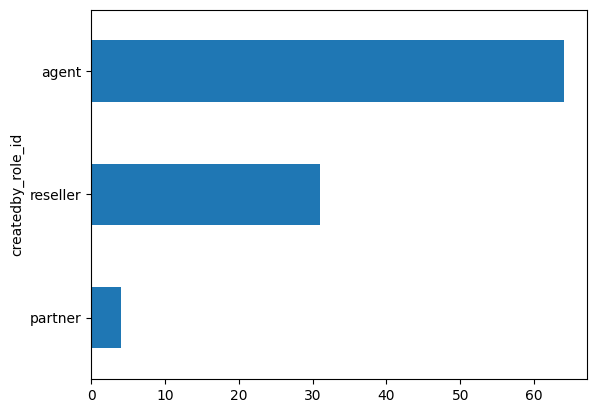

In [ ]:
df[(df['booked_n_days_before'] <0) & (df['vehclass_id'] != 'insurance')].groupby(['createdby_role_id'])['status_id'].agg(['count']).sort_values(by='count').plot(kind='barh',legend=False)

## Add Purchase type

In [ ]:
first_purchase = df.groupby(['cust_id'])['createdon'].agg(['min']).reset_index()
first_purchase.rename(columns={'min':'first_purchase_date'}, inplace=True)
df = df.merge(first_purchase, on='cust_id', how='left')
df['purchase_type'] = df.apply(lambda x: 'First purchase' if x['createdon'] == x['first_purchase_date'] else 'Repeat purchase', axis=1)


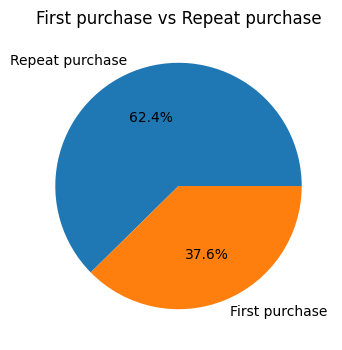

In [30]:
plt.figure(figsize=(6, 4))
df[df['vehclass_id']!='insurance']['purchase_type'].value_counts().plot(kind='pie',autopct='%1.1f%%')
plt.ylabel('')
plt.title('First purchase vs Repeat purchase')
plt.show()

# Summarize

From the Exploratory, we can conclude some features and issues exist within the dataset:
1. Features:
    - **Booking & Transaction Characteristics**: 
        - Payments are concentrated between severals providers like ecommpay, omise, paypal and mostly in APAC region currencies, especially THB.
        - Booking are mainly created by agent and partner while user direct booking is minimal.
        - Majority of the booking are for two or below seats and close to departure date with median is 3 days and 75% within 13 days.
    - **Geographic & Route Features**:
        - Most of bookings are domestic travel. Small number of routes account for large percentage of all bookings.
    - **Customer & Channel Insights**:
        - Top 4 channel constitutes 85% of all bookings, large proportion are paid and affiliate. Moreover, most of the booking refered from search engine suggesting great performance from search ads.
    - **Supplier insights**:
        - Omit from current exploratory due to lack of information.
2. Issues:
    - **Data quality and consistency**:
        - Booking Status: "PAID" status given unclear information and has little count compare to other statuses. The status "REFUNDED" also not associate with "refund_usd".
        - Trip duration: Some trips have negative durations while some have extremely long duration. The values are abnormal and need investigation.
        - Booking Leadtime: Some records have created date after the actual travel date, which does not make sense for any platform.
        - Financial total discrepancy: Compare with the formular total = (netprice+sysfee+agfee)*seat, the total is up $35K USD. The system fee is also up around $2Millions USD while agent fee is down for ~$2.1Millions USD. The discrepancy might due to rounding when exchange to USD, however, the large different in system fee and agent fee total suggest investigate how stored data derived or it is an error.
3. Next steps:
    - **Data cleaning**: Will need feedback from the team to resolve this. Atm, assuming the data is sane and correct. Applied transformation and cleaning are integrated in _*wrangle*_ function
    - **Further Analysis**:
        - Profitability: Calculate company margin across some dimensions: route, user origin, booking channel, preference (vehicle & class)
        - Trend and Seasonality: Key metrics over time and travel season. Preference changes between 2019 and 2023
    - **Forming Key metrics**


In [31]:
## Exporting the data for further analysis
df.to_parquet(os.path.join(os.getcwd(),'post_clean.parquet'))